In [1]:
import sys, os
import datetime
from settings import *

sys.path.insert(0, PYSBF_PATH)
from pysbf import *

from IPython.display import display, Markdown, clear_output

import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary cache directory at /tmp/matplotlib-shfhuj3p because the default path (/home/sbf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Set galaxy name

In [2]:
name = "u12517"

### Initializiation

- Read some output parameters from the ouput data generated by `elliprof`

In [3]:
outFolder = OUT_FOLDER + "Outputs_"+name+'/'
logFile = outFolder+name+"_model_log.csv"

df_log = open_log_df(logFile)
sky_med = float(df_log.loc["initial_sky_med"].value)

df = open_log_df(logFile)
obj_uuid = df.loc['uuid'].value
objRoot = outFolder+name+'_'+obj_uuid+'/'

X0 = float(df.loc['X0'].value)
Y0 = float(df.loc['Y0'].value)

Config = {} 
Config["name"] = name
Config["inFolder"] = IN_FOLDER
Config["objRoot"] = objRoot
Config["configFolder"] = CONFIG_FOLDER
Config["X0"] = X0
Config["Y0"] = Y0
Config["SKY"] = df.loc["sky"].value

In [4]:
## renuc factors for Sextractor
## 100 Mpc renuc = 1.5
## 20 Mpc renuc = 7


### Defining the radius of the central zone t

where Source Extractor avoids finding point source objects 

In [5]:
avoiding_r = widgets.FloatSlider(
                    value=20,
                    min=1,
                    max=200,
                    step=1,
                    description="R_aperture",
                )

print("Radius of the avoding zone [pix]")
display(avoiding_r)

Radius of the avoding zone [pix]


FloatSlider(value=20.0, description='R_aperture', max=200.0, min=1.0, step=1.0)

### Run Source Extractor 

to find point source objects, extended objects and build masks

In [6]:
# used Dmask instead of mask1
catalName, catal_df, se_objname, se_mask, se_masked, residual, segment = SE_foreground(model=0, 
                                       smooth=1.0, minArea=10, thresh=2.5,
                                       r_aperture = avoiding_r.value,   # [pixel] ignore objects within the aperture
                                       renuc=2, 
                                       Extended = False,
                                        **Config) 

catal_df.head()

/home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/obj.000.pro


NUMBER   X_IMAGE   Y_IMAGE  ALPHA_J2000  DELTA_J2000  MAG_AUTO  \
0       1  221.2979  109.8596   349.949773    43.960428  -14.7706   
1       2  866.7762   38.4435   349.972772    43.978381  -12.3380   
2       3   18.5073   36.4298   349.939549    43.957188  -11.5114   
3       4  972.8853   20.5129   349.976361    43.981488  -13.2506   
4       5  588.4511   11.5703   349.961048    43.972085  -14.2310   

   MAGERR_AUTO  A_IMAGE  B_IMAGE  THETA_IMAGE  ...  MAGERR_APER_1  \
0       0.0013    6.277    3.132        84.70  ...         0.0042   
1       0.0059    5.809    2.571       -89.45  ...         0.0135   
2       0.0131    5.890    3.671        78.84  ...         0.0325   
3       0.0029    3.999    2.856       -86.02  ...         0.0068   
4       0.0017    4.295    3.403        67.85  ...         0.0044   

   MAGERR_APER_2  MAGERR_APER_3  MAGERR_APER_4  MAGERR_APER_5  MAG_ISO  \
0         0.0034         0.0033         0.0021         0.0017 -14.8159   
1         0.0113         0.0105         0.0070         0.0062 -13.2604   
2         0.0292         0.0267         0.0168         0.0140 -12.1729   
3         0.0054         0.0053         0.0035         0.0030 -13.2880   
4         0.0040         0.0036         0.0023         0.0020 -14.2814   

   MAGERR_ISO  MAG_ISOCOR  MAGERR_ISOCOR          rc  
0      0.0013    -14.8342         0.0015  570.029949  
1      0.0033    -13.3226         0.0044  603.525475  
2      0.0075    -12.5290         0.0146  760.531351  
3      0.0028    -13.3173         0.0033  676.834547  
4      0.0017    -14.2946         0.0018  551.437564  

[5 rows x 33 columns]

## Use DS9 and keep it open while working interatively

Open ds9 and wait for its window to fully appear on the screen.

Probably, the most helpful image is the residual image.

In [7]:
# print("se_mask: ", se_mask)
# print("se_masked: ", se_masked)
# print("residual: ", residual)
# print("se_objname: ", se_objname)

_ = CMD_button("ds9 "+se_mask+" &", "[DS9] se_mask")
_ = CMD_button("ds9 "+se_masked+" &", "[DS9] se_masked")
_ = CMD_button("ds9 "+residual+" &", "[DS9] residual >>>")
_ = CMD_button("ds9 "+se_objname+" &", "[DS9] se_objname")

### [DS9] Regions Guide 

- Green: extended opbject
- Cyan: star, point source
- Yellow: ignored or avoding zone

In [8]:
print("Radius of the avoding zone [pix]")
display(avoiding_r)

Radius of the avoding zone [pix]


FloatSlider(value=20.0, description='R_aperture', max=200.0, min=1.0, step=1.0)

### Run Source Extractor multiple tiles

and build point source catalog for likenew. You can alter the radius of the avoidance zonce in the above cell.

In [9]:
catalName, catal_df, sex_objname, se_mask, se_masked, residual, segment = SE_foreground(
                                       model=0,
                                       smooth=1.0, minArea=5, thresh=2,
                                       r_aperture = avoiding_r.value,   # [pixel] ignore objects within the aperture
                                       renuc=2,
                                        **Config) 

# making point source catalogs for likenew
lkn_file_name, ingore_id_list = make_se_lkn(catal_df, model=0, star_f=0.7, zp = 35.081,
                            r_aperture=avoiding_r.value, Extended=False,
                            **Config)

_ = CMD_button("ds9 "+residual+" &", "[DS9] residual")
reg_button = ds9_region_display(reg_file="./ds9.reg")
_ = Logtext(lkn_file_name, "lkn file")

resid = residual.rsplit('/', 1)[-1]
lkn = lkn_file_name.rsplit('/')[-1]
lkn6 = "{}j.lkn6".format(lkn.rsplit('.')[0])
ptm6 = "{}j.ptm6".format(lkn.rsplit('.')[0])

like_pack = [lkn, lkn6, ptm6, resid]

/home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/obj.000.pro
wrote:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/u12517_se_lknj.000
number of lines:  43
# of GCs:  4
# of galaxies:  50


XPA$ERROR no 'xpaset' access points match template: ds9
XPA$ERROR no 'xpaset' access points match template: ds9


### Build an extra mask for extended objects

- These are the objects that are not included in the LF list, and we want to mask them. 
- To do so we use the segmentation image created by ds9
- `ingore_id_list` holds the id of these objects
- `segment` is the segmentation file generated by source extractor

In [10]:
segment

'/home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35//objCheck.000.segment'

In [11]:
extra_mask_name = "extra_mask.fits"

In [12]:
# if invert == True
# everywhere 1
# msked object 0
_ = seg2mask(segment, objRoot+extra_mask_name, good_segments=ingore_id_list, invert=True)

<Axes: >

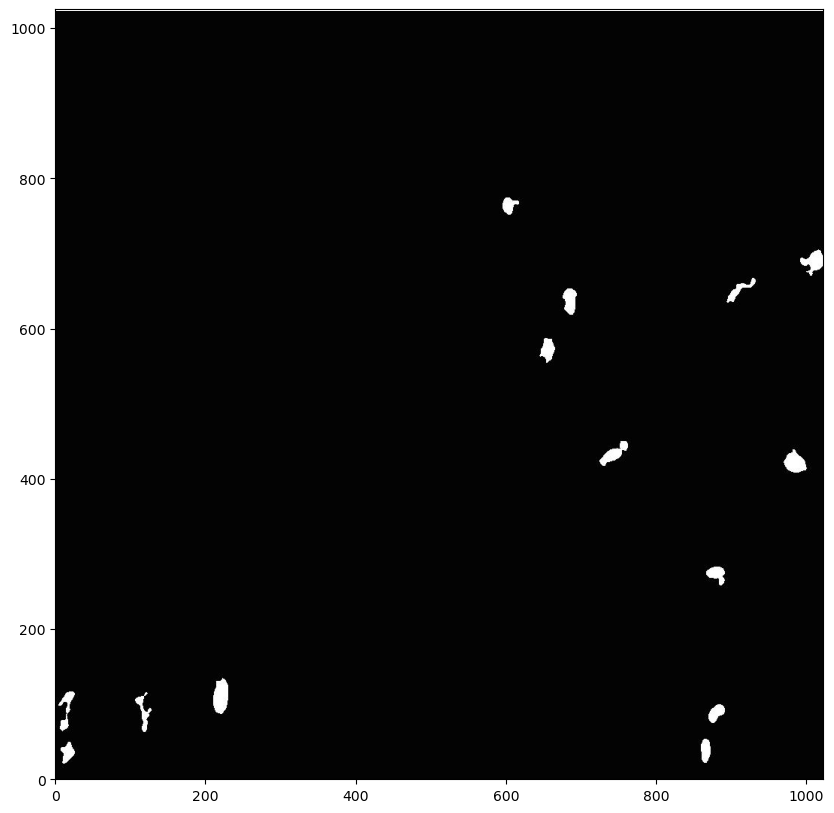

In [13]:
tv(objRoot+extra_mask_name)

## Run LikeNew

In [14]:
like_pack

['u12517_se_lknj.000',
 'u12517_se_lknjj.lkn6',
 'u12517_se_lknjj.ptm6',
 'resid.000']


cp /home/sbf/data_in/wfc3//u12517/u12517j.dmask /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/.
 LIKENEW6 -- IR version 2020
 FWHM:   1.39999998    
 distance:   65.0000000    
 kscale:   1.2000000476837158     
 delta:   1.39999998    
 snlim:   4.50000000    
 mlim:   21.0000000    
   43 sources found,   33 used for fits;  sky radius = 550
 Using Mv = -7.40 for GCs (NOT for JHK)
 Using AB mags for JHK
 Using galaxy slope gamma =  0.25 
 Using 34.50 normalization for 1 gal/arcsec
BETA wall hit very hard       4.25E+82
 A(I) = 0.5000     0.6000    
 F =   36207.92        ITER =   0   LAMBDA =  -3
BETA wall hit very hard       4.25E+82
BETA wall hit very hard       4.25E+82
BETA wall hit very hard       4.25E+82
BETA wall hit very hard       4.25E+82
Beta  =	      0.0000e+00 	 #gxy / total sources

Cnorm =	      0.0000e+00 	 GC normalization
Cmax  =	      0.000 		 GC peak magnitude
Delta =	      1.4 		 GC distribution width
Alpha =	      0.000 		 GC log slope vs log r
Tot

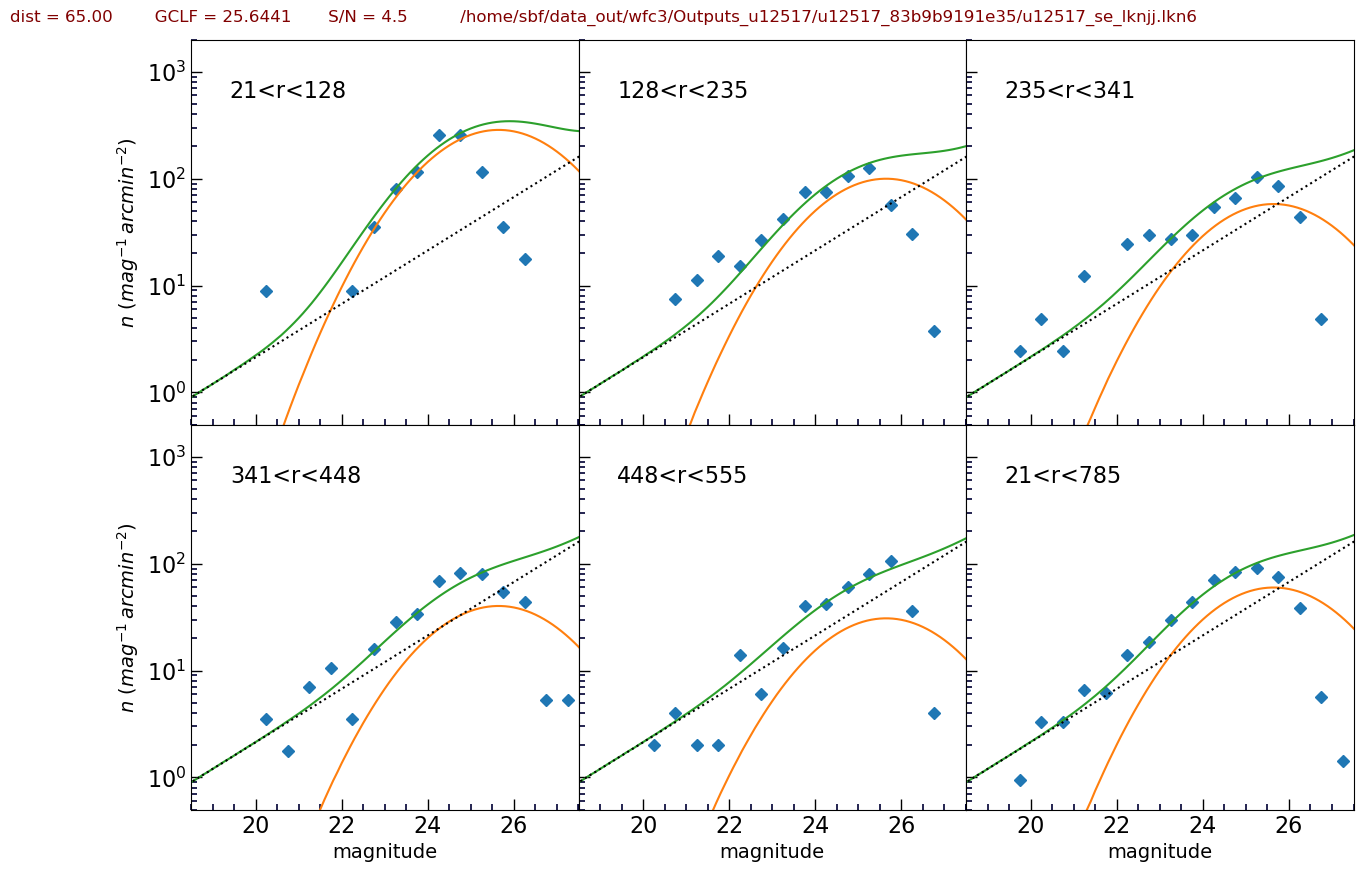

In [15]:
pylike(like_pack, 
            gclf_width=1.4, 
            distance=65, 
            bright_cutoff=21, 
            kscale=1.2, plot=True,
            **Config)

# code to display the button
_ = Logtext(os.path.join(objRoot, "{}j.lkn6".format(lkn.rsplit('.')[0])), "lkn6")

### LikeNew point source mask

In [16]:
ptm6

'u12517_se_lknjj.ptm6'

### merge masks and update the residual image

residual file ready for dophot:  update_resid.000


<Axes: >

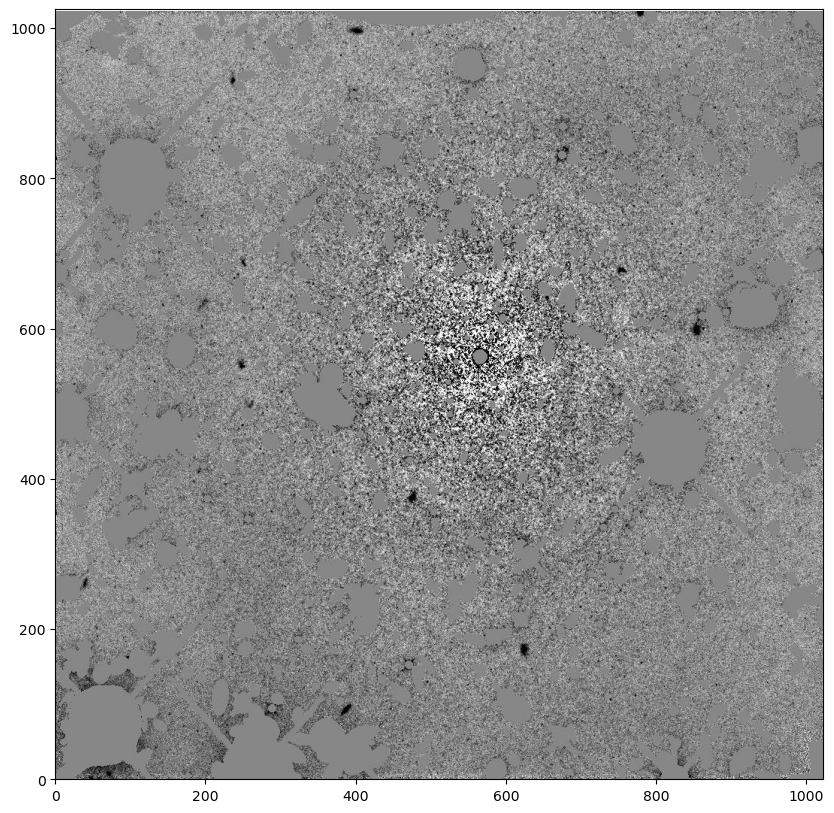

In [17]:
update_resid = resid_ptm6(resid, [ptm6, extra_mask_name], outfile='update_resid.000', **Config)
# outfile = resid_ptm6(resid, [ptm6], outfile='test.000', **Config)
tv(os.path.join(objRoot, update_resid))

### check the updated residual on DS9


In [18]:
! ds9 {objRoot}/update_resid.000

## Tidy commands

to edit the filter mask

<img src="img/tidy.jpg" alt="Alternative text" />

### [Monsta] Tidy command to edit the mask manually

- press `x` to edit, i.e. adding a mask of the specified size under the cursor
- press `e` to save

### Parameters:

- self
    - False: ptm6 --> ptm6b
    - True: ptm6 --> ptm6b  (continue editing)
    
- rad
    - mask radius [pixel]

In [19]:
like_pack[3] = update_resid
edit_ptm6_mask(like_pack, self=True, rad=5, **Config)

modified mask name: u12517_se_lknjj.ptm6b
backup: u12517_se_lknjj.ptm6b.20250310165749


'u12517_se_lknjj.ptm6b'

In [20]:
display_ptm6_mask(like_pack, **Config)

In [21]:
catalName, catal_df, sex_objname, se_mask, se_masked, residual, segment = SE_foreground(
                                       model=0,
                                       smooth=1.0, minArea=5, thresh=2.0,
                                       r_aperture = avoiding_r.value,   # [pixel] ignore objects within the aperture
                                       renuc=2,
                                        **Config) 

lkn_file_name, ingore_id_list = make_se_lkn(catal_df, model=0, star_f=0.7, zp = 35.081,
                            r_aperture=avoiding_r.value, Extended=True, sfx='segal',
                            **Config)

_ = CMD_button("ds9 "+residual+" &", "[DS9] residual")
reg_button = ds9_region_display(reg_file="./ds9.reg")
_ = Logtext(lkn_file_name, "lkn file")

resid = residual.rsplit('/', 1)[-1]
lkn_segal = lkn_file_name.rsplit('/')[-1]
lkn6 = "{}j.lkn6".format(lkn_segal.rsplit('.')[0])
ptm6 = "{}j.ptm6".format(lkn_segal.rsplit('.')[0])

like_pack = [lkn_segal, lkn6, ptm6, resid]


/home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/obj.000.pro
wrote:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/u12517_segal_lknj.000
number of lines:  39
# of GCs:  4
# of galaxies:  50


XPA$ERROR no 'xpaset' access points match template: ds9
XPA$ERROR no 'xpaset' access points match template: ds9


In [22]:
def update_ptm6(ptm6, all_masks, outfile=None, **Config):

    objRoot = Config["objRoot"]
    name = Config["name"]
    
    if outfile is None:
        outfile = "{}_updated.ptm6b".format(name)
        
    cwd = os.getcwd()
    os.chdir(objRoot)
    monsta_script = """
        rd 1 """+ptm6
    
    
    for mask in all_masks:
        monsta_script+="""
        rd 2 """+mask+"""
        mi 1 2
        """
        
    monsta_script += """di 1 1
    """
    monsta_script += """wd 1 """+outfile+""" bitmap
    """

    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')
    print("residual file ready for dophot: ", outfile)
    os.chdir(cwd)
    
    return outfile

In [23]:
ptm6

'u12517_segal_lknjj.ptm6'

In [24]:
like_pack

['u12517_segal_lknj.000',
 'u12517_segal_lknjj.lkn6',
 'u12517_segal_lknjj.ptm6',
 'resid.000']

In [25]:
pylike(like_pack, 
            gclf_width=1.4, 
            distance=60, 
            bright_cutoff=20.5, 
            kscale=1.2, plot=False,
            **Config)


cp /home/sbf/data_in/wfc3//u12517/u12517j.dmask /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/.
 LIKENEW6 -- IR version 2020
 FWHM:   1.39999998    
 distance:   60.0000000    
 kscale:   1.2000000476837158     
 delta:   1.39999998    
 snlim:   4.50000000    
 mlim:   20.5000000    
   39 sources found,   30 used for fits;  sky radius = 550
 Using Mv = -7.40 for GCs (NOT for JHK)
 Using AB mags for JHK
 Using galaxy slope gamma =  0.25 
 Using 34.50 normalization for 1 gal/arcsec
BETA wall hit very hard       1.80E+93
 A(I) = 0.5000     0.6000    
 F =   46118.20        ITER =   0   LAMBDA =  -3
BETA wall hit very hard       1.80E+93
Beta  =	      0.0000e+00 	 #gxy / total sources

Cnorm =	      0.0000e+00 	 GC normalization
Cmax  =	      0.000 		 GC peak magnitude
Delta =	      1.4 		 GC distribution width
Alpha =	      0.000 		 GC log slope vs log r
Total # GC =  0.0

Gamma =	      0.00000 		 Gxy log slope vs m
Gnorm =	      0.00000 		 Gxy count / 1/" @  0.00
Tnorm =	

In [26]:
# if invert == True
# everywhere 1
# msked object 0
_ = seg2mask(segment, Config["objRoot"]+"test.fits", good_segments=ingore_id_list, invert=True)

residual file ready for dophot:  test.000


<Axes: >

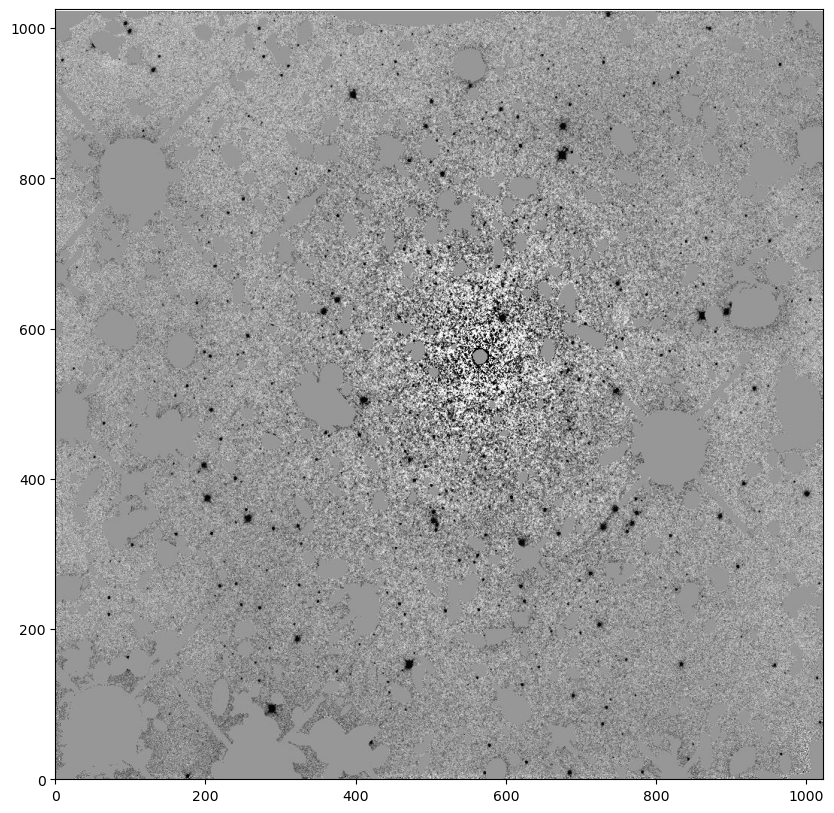

In [27]:
# outfile = resid_ptm6(resid, [ptm6, "test.fits"], outfile='test.000', **Config)
outfile = resid_ptm6(resid, [ptm6, "test.fits"], outfile='test.000', **Config)
tv(os.path.join(objRoot, outfile))

In [28]:
outfile = update_ptm6(ptm6, ["test.fits"], outfile=ptm6, **Config)

residual file ready for dophot:  u12517_segal_lknjj.ptm6


In [29]:
# like_pack[3] = outfile

In [30]:
edit_ptm6_mask(like_pack, self=True, rad=5, **Config)

modified mask name: u12517_segal_lknjj.ptm6b
backup: u12517_segal_lknjj.ptm6b.20250310165756


'u12517_segal_lknjj.ptm6b'

In [31]:
do_resid_image = resid_ptm6(resid, [ptm6+"b"], outfile="{}.2dophot".format(resid), **Config)
do_resid_image

residual file ready for dophot:  resid.000.2dophot


'resid.000.2dophot'

<Axes: >

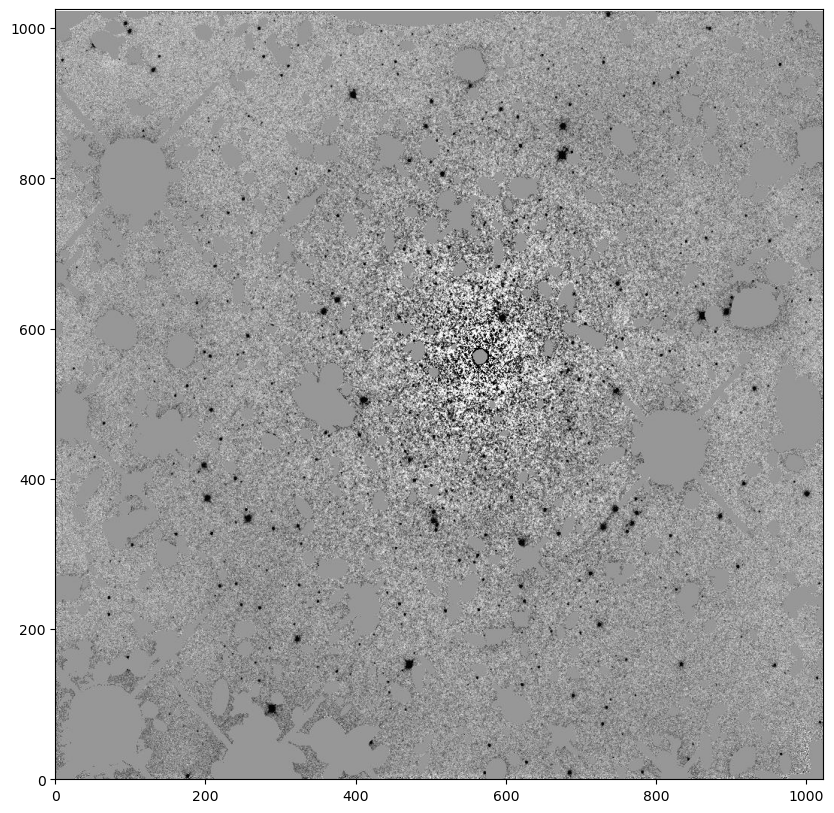

In [32]:
tv(os.path.join(objRoot, do_resid_image))

In [33]:
# used Dmask instead of mask1
log, resid_file, dpar_file, image_in, image_out, dpo_file = DoPhot(model=0, renuc=2, 
                                                                   image_in = do_resid_image,
                                                                   object_out = "{}.hybrid.dpo".format(name),
                                                                   **Config) 

# print("log file: ", log)
_ = Logtext(log, "log")

# print("dpar file: ", dpar_file)
_ = Logtext(dpar_file, "Dpar File")

if os.path.exists(image_in):
    print("input image: ", image_in)
    _ = CMD_button("ds9 "+image_in+" &", "[DS9] input image")
else:
    print("input image not found: ", image_in)

# if os.path.exists(resid_file):
#     print("residual image: ", resid_file)
#     _ = CMD_button("ds9 "+resid_file+" &", "[DS9] residual image")
# else:
#     print("residual image not found: ", resid_file)

print("dpo file: ", dpo_file)
if dpo_file is not None:
    _ = Logtext(dpo_file, "DPO File")
    
# print("output image: ", image_out)
# if image_out is not None:
#     _ = CMD_button("ds9 "+image_out+" &", "[DS9] dpr image")

reg_button = ds9_region_display(reg_file="./ds9.reg")

input image:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/resid.000.2dophot


dpo file:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/u12517.hybrid.dpo


XPA$ERROR no 'xpaset' access points match template: ds9
XPA$ERROR no 'xpaset' access points match template: ds9


In [34]:
print("Radius of the avoding zone [pix]")
display(avoiding_r)

Radius of the avoding zone [pix]


FloatSlider(value=20.0, description='R_aperture', max=200.0, min=1.0, step=1.0)

In [35]:
DF, lkn_dophot = make_do_lkn(dpo_file, model=0, r_aperture=avoiding_r.value, 
                                    exclude457=False, 
                                    ZP=35.081, 
                                    **Config)

_ = Logtext(lkn_dophot, "lkn file")

like_pack = (lkn_dophot, lkn6, ptm6, do_resid_image) #resid)

wrote:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/u12517_do_lkn.000
number of lines:  535
GCs:  246
galaxies:  27
Including dophot object types 4, 5, and 7


In [36]:
like_pack

('/home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/u12517_do_lkn.000',
 'u12517_segal_lknjj.lkn6',
 'u12517_segal_lknjj.ptm6',
 'resid.000.2dophot')

In [37]:
lkn_dophot

'/home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/u12517_do_lkn.000'

In [38]:
_ = Logtext(os.path.join(objRoot, lkn_segal), "segal")
_ = Logtext(os.path.join("./", lkn_dophot), "dophot")

In [39]:
segal = os.path.join(objRoot, lkn_segal)
dophot = os.path.join("./", lkn_dophot)

with open(segal, "r") as f:
    with open(dophot, "r") as g:
        
        se_lines = f.readlines()
        do_lines = g.readlines()
        


In [40]:
with open(os.path.join(objRoot, "hybrid.lknj"), "w") as f:
    
    for i in range(0, len(se_lines)):
        line = se_lines[i]
        f.write(line)
        
    for i in range(len(do_lines)):
        line = do_lines[i]
        f.write(line)
    
_ = Logtext(os.path.join(objRoot, "hybrid.lknj"), "hybrid")

In [41]:
lkn = "hybrid.lknj"

lkn6 = "{}j.lkn6".format(lkn.rsplit('.')[0])
ptm6 = "{}j.ptm6".format(lkn.rsplit('.')[0])

like_pack = (lkn, lkn6, ptm6, do_resid_image) # "resid.000")

In [42]:
like_pack

('hybrid.lknj', 'hybridj.lkn6', 'hybridj.ptm6', 'resid.000.2dophot')


cp /home/sbf/data_in/wfc3//u12517/u12517j.dmask /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/.
 LIKENEW6 -- IR version 2020
 FWHM:   1.39999998    
 distance:   70.0000000    
 kscale:   1.2000000476837158     
 delta:   1.39999998    
 snlim:   4.50000000    
 mlim:   22.0000000    
  574 sources found,  506 used for fits;  sky radius =  60
 Using Mv = -7.40 for GCs (NOT for JHK)
 Using AB mags for JHK
 Using galaxy slope gamma =  0.25 
 Using 34.50 normalization for 1 gal/arcsec
 A(I) = 0.5000     0.6000    
 F =   7.869993        ITER =   0   LAMBDA =  -3
LIKELY: bad value for BETA      1.6883
   1.0000000000000000     
LIKELY: bad value for BETA      1.6921
   1.0000000000000000     
LIKELY: bad value for BETA      1.7339
   1.0000000000000000     
LIKELY: bad value for BETA      3.0731
   1.0000000000000000     
 A(I) = 0.4461      1.806    
 F =   7.621194        ITER =   1   LAMBDA =   0
 A(I) = 0.5269      1.959    
 F =   7.603387        ITER =   2   LAMBDA =  -

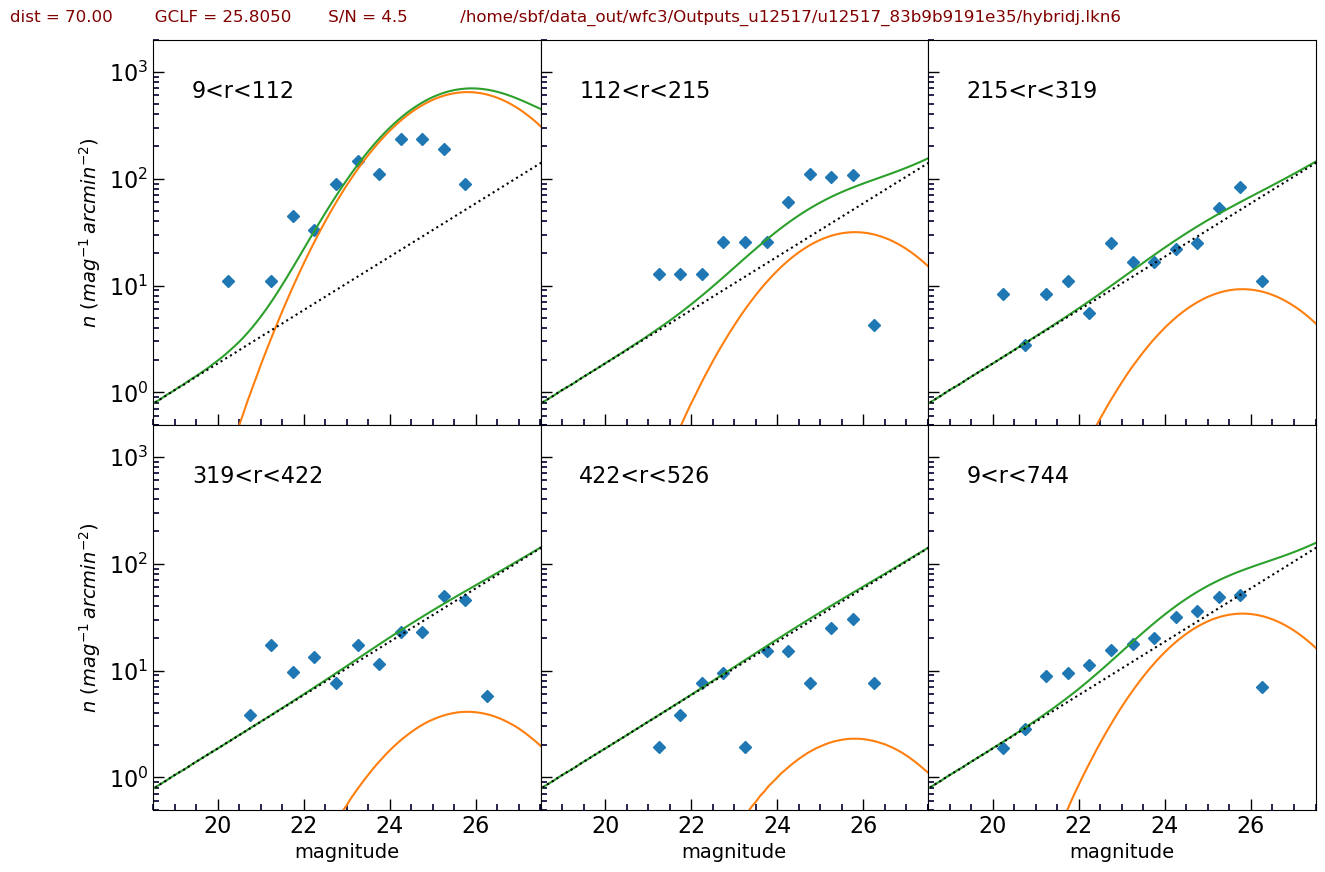

In [43]:
pylike(like_pack, 
            gclf_width=1.4, 
            distance=70, 
            bright_cutoff=22, 
            kscale=1.2, plot=True,
            **Config)

_ = Logtext(os.path.join(objRoot, "hybridj.lkn6"), "hybrid")

In [44]:
like_pack

('hybrid.lknj', 'hybridj.lkn6', 'hybridj.ptm6', 'resid.000.2dophot')

In [45]:
final_mask = edit_ptm6_mask(like_pack, self=True, rad=5, **Config)

modified mask name: hybridj.ptm6b
backup: hybridj.ptm6b.20250310165820


In [46]:
ptm6

'hybridj.ptm6'

residual file ready for dophot:  test.000


<Axes: >

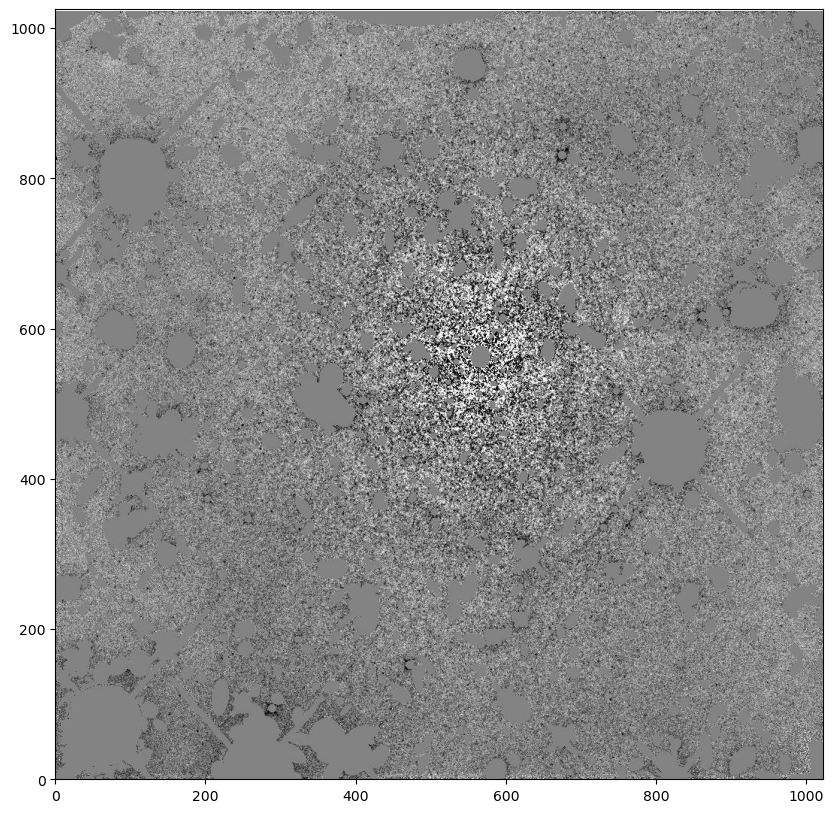

In [47]:
outfile = resid_ptm6(resid, [ptm6+"b", "test.fits"], outfile='test.000', **Config)

tv(os.path.join(objRoot, outfile))